### Binary Sentiment Classification

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

e:\apps\anaconda\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 资料
- https://zhuanlan.zhihu.com/p/77634533
#### 一维卷积
- 图片的channel实际上相当于一个特征，所以channel=embedding

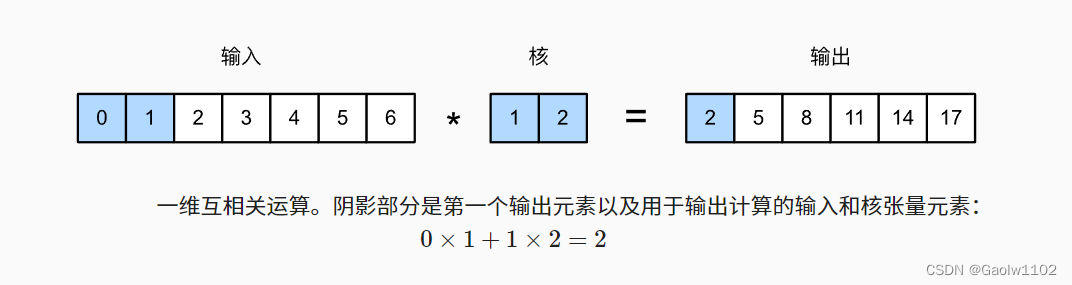
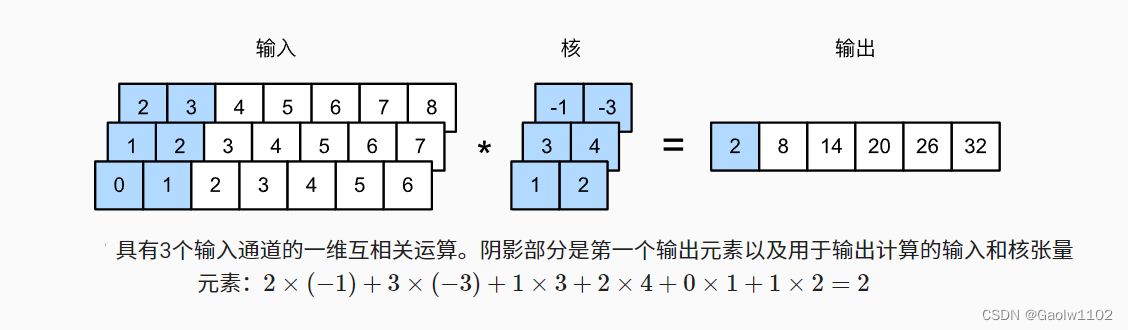
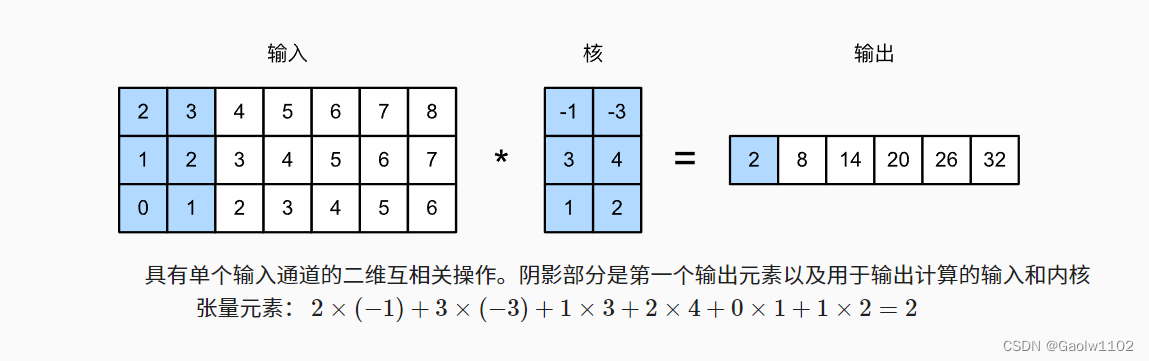

In [2]:
embedding_size = 2 # embedding size
sequence_length = 3 # sequence length
num_classes = 2 # number of classes
filter_sizes = [2, 2, 2] # n-gram windows
num_filters = 3 # number of filters

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

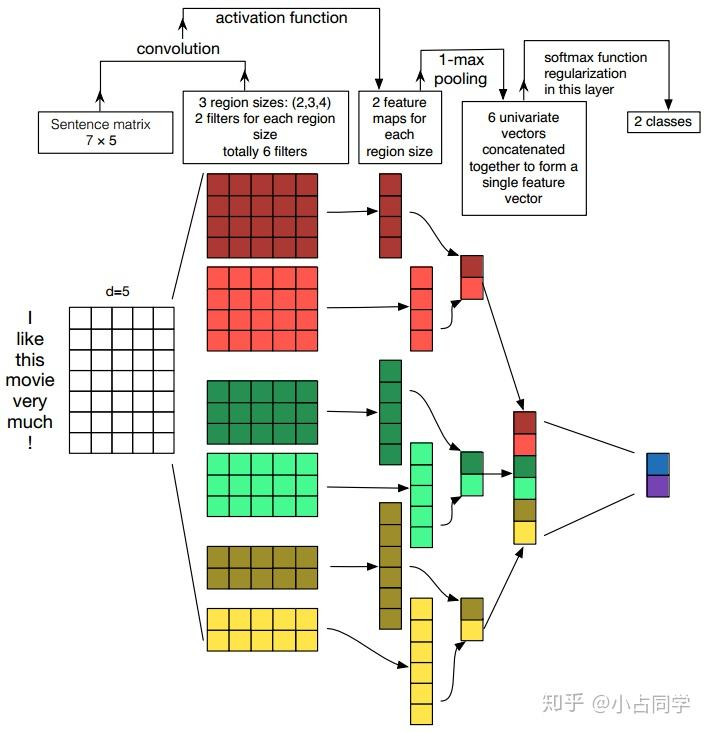

In [3]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.num_filters_total = num_filters * len(filter_sizes)
        self.W = nn.Embedding(vocab_size, embedding_size)
        self.Weight = nn.Linear(self.num_filters_total, num_classes, bias=False)
        self.Bias = nn.Parameter(torch.ones([num_classes]))
        # （输入通道数，输出通道数，(卷积核形状)）
        self.filter_list = nn.ModuleList([nn.Conv2d(1, num_filters, (size, embedding_size)) for size in filter_sizes])
        # *conv2d 会根据输出channels数目创建对应数目的卷积核

    import pysnooper
    @pysnooper.snoop("./log.txt")
    def forward(self, X):
        embedded_chars = self.W(X) # [batch_size, sequence_length, sequence_length]
        # ! unsqueeze(i) 在第i个维度添加一个一维
        # *这里如果我们使用多个词嵌入矩阵的话，也可以调整输入channels为词嵌入矩阵数
        embedded_chars = embedded_chars.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]

        pooled_outputs = []
        for i, conv in enumerate(self.filter_list):
            # conv : [input_channel(=1), output_channel(=3), (filter_height, filter_width), bias_option]
            h = F.relu(conv(embedded_chars))  # [batch_size, channels(=3), sequence_lenth, embedding_size]=>[batch_size=6, channels(=3), sequence_lenth-filter_sizes[i]+1, 1]
            # mp : ((filter_height, filter_width))
            mp = nn.MaxPool2d((sequence_length - filter_sizes[i] + 1, 1)) 
            # !通过 `permute` 函数，我们将其维度顺序改为 `pooled : [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3)]`
            pooled = mp(h).permute(0, 3, 2, 1)
            pooled_outputs.append(pooled)

        # *(张量， 指定维度)，cat沿着指定维度将张量进行拼接
        h_pool = torch.cat(pooled_outputs, len(filter_sizes)) # [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3) * 3]
        h_pool_flat = torch.reshape(h_pool, [-1, self.num_filters_total]) # [batch_size(=6), output_height * output_width * (output_channel * 3)]
        model = self.Weight(h_pool_flat) + self.Bias # [batch_size, num_classes]
        return model

In [4]:
model = TextCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
targets = torch.LongTensor([out for out in labels]) # To using Torch Softmax Loss function

C:\Users\hellow\AppData\Local\Temp\ipykernel_13168\1889812718.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])


In [5]:
# Training
for epoch in range(5000):
    optimizer.zero_grad()
    output = model(inputs)

    # output : [batch_size, num_classes], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, targets)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.003017
Epoch: 2000 cost = 0.000548
Epoch: 3000 cost = 0.000190
Epoch: 4000 cost = 0.000083
Epoch: 5000 cost = 0.000040


In [6]:
# Test
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = torch.LongTensor(tests)

# Predict
predict = model(test_batch).data.max(1, keepdim=True)[1]
if predict[0][0] == 0:
    print(test_text,"is Bad Mean...")
else:
    print(test_text,"is Good Mean!!")

sorry hate you is Good Mean!!
